#### NLP | Model

# Coronavirus Tweets: April 2020<a id='top'></a>

### Natural Language Processing Stepwise Analysis

1. Research Question<br/>
2. DataFrames<br/>
3. Exploratory Data Analysis<br/>
   Data Summary<br/>
4. Preprocessing<br/>
   Clean Text<br/>
   Stop Words<br/>
   Stemming<br/>
5. Vectorizer<br/>
6. Topic Modeling/Dimensionality Reduction<br/>
7. Sentiment Analysis<br/>
8. Classification<br/>
    1 Naive Bayes: Gaussian<br/>
    2 Naive Bayes: Multinomial<br/>
9. Data Visualization<br/>  

In [17]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pickle
import re
import en_core_web_sm
import string
pd.set_option('display.max_colwidth', None)


nltk.download('stopwords')
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize #?
from sklearn.decomposition import PCA, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1 | Research Design<a id='1'></a>

* **Research Question:** What were Americans tweeting about coronavirus and COVID-19 in April 2020?
* **Impact Hypothesis:** Inform CDC's communication strategy for future pandemics.
* **Data source:** Coronavirus COVID-19 Tweets [early](https://www.kaggle.com/datasets/smid80/coronavirus-covid19-tweets-early-april) and [late](https://www.kaggle.com/datasets/smid80/coronavirus-covid19-tweets-late-april) April, n=138,796


# 2 | [DataFrames](https://github.com/slp22/nlp-project/blob/main/nlp-coronavirus-tweets-mvp.ipynb)<a id='2'></a>

In [2]:
# load tweets selected for mvp
tweets_df = pd.read_csv('/content/tweet_df.csv', low_memory=False)


In [3]:
tweets_df.head(5)

,created_at,screen_name,text,country_code,account_lang,verified,lang
0,2020-04-06T00:00:05Z,WFMGINC,....#SUNDAYFUNDAY #coronavirus style #vino cheers 🍷 https://t.co/SrymChBkq2,US,NaN,False,en
1,2020-04-06T00:00:14Z,jpomietlasz,"This pandemic has confirmed my worst fears, most people don’t know how to make entertaining videos. #Covid_19 #SinceIveBeenQuarantined #AmericasUnfunniestVideos #WrestleMania #tonyaharding",US,NaN,False,en
2,2020-04-06T00:00:17Z,harold0719,Is this true? \nhttps://t.co/Xj2zdFe7ab\n#EcuadorEnEmergencia #Covid_19 #CoronavirusPandemic,US,NaN,False,en
3,2020-04-06T00:00:18Z,uche_blackstock,"Many us thought it was Wuhan province, but it could never be us. Then it was Italy, but it could never be us. Now it is here. One #NewYorker died every 12 minutes from #COVID19 over this weekend. Absolutely devastating.\n\nhttps://t.co/h5woMTfSCH",US,NaN,True,en
4,2020-04-06T00:00:18Z,BrentALang,Ah #coronavirus humor https://t.co/1yXAZXNIgz,US,NaN,True,en


In [4]:
# cdc = [tweets_df[col].astype(str).str.contains("CDCgov", na=False) for col in tweets_df]
# cdc.count('True')
screen_names_count = tweets_df.screen_name.nunique()
screen_names_list = list(tweets_df.screen_name)

In [5]:
print('cdcgov' in screen_names_list)

False


# 3 | Exploratory Data Analysis<a id='3'></a>

##### Note: Full EDA part of [MVP](https://github.com/slp22/nlp-project/blob/main/nlp-coronavirus-tweets-mvp.ipynb).

### Data Summary<a id='31'></a>

In [6]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138796 entries, 0 to 138795
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   created_at    138796 non-null  object
 1   screen_name   138790 non-null  object
 2   text          138789 non-null  object
 3   country_code  138789 non-null  object
 4   account_lang  2 non-null       object
 5   verified      138787 non-null  object
 6   lang          138787 non-null  object
dtypes: object(7)
memory usage: 7.4+ MB


#### All data types are objects. The column `account_lang` is mostly null values, will drop in next step.

## 4 | Preprocessing<a id='4'></a>  

In [7]:
# isolate text, drop other columns
# save as text_df

text_df = tweets_df.drop(columns=['created_at',
                                  'screen_name',
                                  'country_code',
                                  'account_lang',
                                  'verified',
                                  'lang'])
print(type(text_df))
text_df.head(2)

<class 'pandas.core.frame.DataFrame'>


,text
0,....#SUNDAYFUNDAY #coronavirus style #vino cheers 🍷 https://t.co/SrymChBkq2
1,"This pandemic has confirmed my worst fears, most people don’t know how to make entertaining videos. #Covid_19 #SinceIveBeenQuarantined #AmericasUnfunniestVideos #WrestleMania #tonyaharding"


### 4.1 Text Cleaning  <a id='41'></a>  

In [8]:
# remove numbers, punctuation, and capital letters
alphanumeric = lambda x: re.sub('\w*\d\w*',' ', str(x))
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

text_df['text'] = text_df.text.map(alphanumeric).map(punc_lower)
text_df.head(2)

,text
0,sundayfunday coronavirus style vino cheers 🍷 https t co
1,this pandemic has confirmed my worst fears most people don’t know how to make entertaining videos sinceivebeenquarantined americasunfunniestvideos wrestlemania tonyaharding


In [9]:
# remove emojis
text_df = text_df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

In [10]:
# remove https t co
link = lambda x: re.sub('https', ' ', str(x))
t_co = lambda x: re.sub('t co', ' ', str(x))

text_df['text'] = text_df.text.map(link).map(t_co)

In [11]:
text_df.head(10)

,text
0,sundayfunday coronavirus style vino cheers
1,this pandemic has confirmed my worst fears most people dont know how to make entertaining videos sinceivebeenquarantined americasunfunniestvideos wrestlemania tonyaharding
2,is this true \n \n ecuadorenemergencia coronaviruspandemic
3,many us thought it was wuhan province but i uld never be us then it was italy but i uld never be us now it is here one newyorker died every minutes from over this weekend absolutely devastating \n\n
4,ah coronavirus humor
5,miami and south florida in general are also staying home \n\nnorth florida thinks their immune to oipfvqymvc
6,how can president trump be flip about a question abou ntinuity of power and contracting the coronavirus when i am around him i dont breathe and we wonder why other americans question and defy the quarantine coronavirustaskforce
7,this is our most desperate hour help us obi wan kenobi you re our only hope starwars weneedaleader
8,face your fears \n business love coronavirus nyc ny la california zoom happy prayer
9,first defense nasal screen coming up on abcsharktank during the outbreak and all of a sudden the guy doesnt seem crazy \n\nsharks redeemed themselves w mega offers \n\npos rona airing mcuban thesharkdaymond kevinolearytv is gonna make a killing replaces mask need


In [12]:
text_df.tail(10)

,text
138786,the nfl draft is here this is something everyone needs right now to get everyones mind off of the coronoavirus
138787,so has now shifted from untested medication to telling us that maybe injecting disinfectant or somehow getting uv rays inside our bodies will cure the virus so tide pods are next coronavirus trumppressconference trumpisanidiot trumppressbriefing wgavormglv
138788,discussing with my dad told him what i learned about typhoidmary on myfavmurder he said he was proud my obsession is helping me deal with my anxiety in regards to our newnormal karenkilgariff ghardstark ssdgm
138789,talkingtaiwan guest emily chen talked about how she manages having her kids at home during this coronavirus pandemic listen until the end for a special offering coronavirus coronavirusoutbreak homeschool coronavirus interview emily chen
138790,report state dept confirms china iran and russia are working together to blame us for
138791,we are thankful triadcleanhome thankful thankfulthursday americaworkstogether smallbusiness community communitylove shoplocal shopsmall highpointnc piedmonttriad triadnc thankyou pandemic humble commercialcleaning smallbusinessowner fjimozmxzo
138792,covidart mixedmedia sheep cartoon diary sketchbookjournal sketchbook coronavirus uncertainty hermit isolation flattenthecurve stopthespread sunshine practice sparetire san diego california
138793,sitting in the office after another hour day and feeling thankful for all those who are sharing life friendship and leadership with me during this crazy time in history friends workfamily leadership
138794,realdonaldtrump ondinebio has been using light to kill viruses and mrsa for years testing happening now in canada solution ready now
138795,starting in just a moment live on facebook or on wxxi tv am follow us here for live updates forum


In [15]:
# save preprocessed tweets as corpus_df
corpus_df = text_df
corpus_df.to_pickle('/content/corpus_df.pkl')
corpus_df.to_csv(r'/content/corpus_df.csv', index=False)

### 4.2 Stop Words  <a id='42'></a>  

In [18]:
# custom stop words
stopwords = nltk.corpus.stopwords.words('english')
new_words = ['also','amp',
             'corona', 'coronavirus', 'one', 'today', 'need',
             'people', 'us', 'pandemic',
             'covid', 'pandemic', 'day',
             'coronaviruspandemic', 'get', 'like', 'time', 'im', 'go',
             'dont', 'would', 'best', 'see', 'making', 'still', 'stay', 'home']
stopwords.extend(new_words)
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### 4.3 Stemming  <a id='43'></a>  

In [20]:
# stemmer
stemmer = SnowballStemmer("english")

def prep(word):
    if word in stopwords:
        return None
    elif stemmer is None:
        return word
    else:
        return stemmer.stem(word)

## 5 | Vectorizer<a id='5'></a>  

In [23]:
# load preprocessed corpus from step 3
df = pd.read_pickle("/content/corpus_df.pkl")
df.head(2)

,text
0,sundayfunday coronavirus style vino cheers
1,this pandemic has confirmed my worst fears most people dont know how to make entertaining videos sinceivebeenquarantined americasunfunniestvideos wrestlemania tonyaharding


In [24]:
corpus = df.text
print('corpus type:', type(corpus))
print(corpus.head(2))

corpus type: <class 'pandas.core.series.Series'>
0                                                                                                                                   sundayfunday  coronavirus style  vino cheers         
1    this pandemic has confirmed my worst fears  most people dont know how to make entertaining videos      sinceivebeenquarantined  americasunfunniestvideos  wrestlemania  tonyaharding
Name: text, dtype: object


### Term Frequency Inverse Document Frequency (TF-IDF)

In [25]:
tf_vectorizer = TfidfVectorizer(stop_words=stopwords,
                                min_df=0.01,
                                max_df=.95,
                                preprocessor=prep)
tf_vectorizer

TfidfVectorizer(max_df=0.95, min_df=0.01,
                preprocessor=<function prep at 0x7809244f0af0>,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [47]:
# document-term matrix with TF-IDF
tf_doc_term_mtx = tf_vectorizer.fit_transform(corpus)
type(tf_doc_term_mtx)

scipy.sparse._csr.csr_matrix

In [27]:
tf_doc_term_df = pd.DataFrame(tf_doc_term_mtx.toarray(),
                              columns=tf_vectorizer.get_feature_names_out())
tf_doc_term_df.head(2)

,america,americans,another,anyone,april,around,away,back,better,business,...,way,week,weeks,well,work,workers,working,world,year,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# double check that domain specfic words were omitted
print('corona' in tf_vectorizer.get_feature_names_out())
print('covid' in tf_vectorizer.get_feature_names_out())
print('co' in tf_vectorizer.get_feature_names_out())
print('amp' in tf_vectorizer.get_feature_names_out())

# who and what are mentioned in the corpus? not cdc, trump mentioned
print('cdc' in tf_vectorizer.get_feature_names_out())
print('cdcgov' in tf_vectorizer.get_feature_names_out())
print('centers for disease control and prevention' in tf_vectorizer.get_feature_names_out())
print('fauci' in tf_vectorizer.get_feature_names_out())
print('redfield' in tf_vectorizer.get_feature_names_out())
print('nih' in tf_vectorizer.get_feature_names_out())
print('fda' in tf_vectorizer.get_feature_names_out())
print('samhsa' in tf_vectorizer.get_feature_names_out())
print('homeland' in tf_vectorizer.get_feature_names_out())
print('medicare' in tf_vectorizer.get_feature_names_out())
print('medicaid' in tf_vectorizer.get_feature_names_out())
print('trump' in tf_vectorizer.get_feature_names_out(), '==> trump')
print('white' in tf_vectorizer.get_feature_names_out())
print('house' in tf_vectorizer.get_feature_names_out(), '==> house')
print('testing' in tf_vectorizer.get_feature_names_out(), '==> testing')

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True ==> trump
False
True ==> house
True ==> testing


## 6 | Topic Modeling/Dimensionality Reduction <a id='6'></a>  

### Non-Negative Matrix Factorization (NMF)

In [29]:
# V     visible variables     doc_term             input (corpus matrix)
# W     weights               doc_topic            feature set
# H     hidden variables      topic_term           coefficients

In [30]:
V = tf_doc_term_mtx
V.shape

(138796, 155)

In [31]:
# W matrix = feature set & weights
nmf = NMF(n_components=3, init=None)
W = nmf.fit_transform(V).round(3)
print(type(W))
W.shape

<class 'numpy.ndarray'>


(138796, 3)

In [48]:
# H matrix = hidden variables & coefficients

H = pd.DataFrame(nmf.components_.round(2),
                 index = ['c1',
                          'c2',
                          'c3'], #,
#                           'c4']#,,
#                           'c5']
                 columns = tf_vectorizer.get_feature_names_out())
print('H.shape:',  H.shape)
H.T.style.background_gradient(cmap='Blues')

H.shape: (3, 155)


,c1,c2,c3
america,0.540000,0.000000,0.010000
americans,0.740000,0.000000,0.000000
another,0.480000,0.070000,0.030000
anyone,0.580000,0.030000,0.000000
april,0.330000,0.040000,0.150000
around,0.470000,0.040000,0.020000
away,0.390000,0.030000,0.010000
back,1.360000,0.070000,0.000000
better,0.540000,0.040000,0.020000
business,0.440000,0.020000,0.020000


In [33]:
# function to display topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

#### Top terms by topic:

In [34]:
display_topics(nmf, tf_vectorizer.get_feature_names_out(), 10)


Topic  0
trump, realdonaldtrump, help, thank, know, going, work, please, virus, health

Topic  1
quarantine, stayhome, quarantinelife, socialdistancing, stayathome, staysafe, lockdown, california, love, stayhomestaysafe

Topic  2
new, york, cases, deaths, city, state, nyc, county, positive, april


## 7 | Sentiment Analysis<a id='7'></a>  

### Vader Sentiment

In [36]:
# analyzer = SentimentIntensityAnalyzer()
# sentiment = analyzer.polarity_scores(text_df).get('compound')
# print('compound_score', sentiment)

In [37]:
# text_df['compound_score'] = text_df.text.map(analyzer.polarity_scores).map(lambda x: x.get('compound'))
# text_df.head(15)

In [39]:
# # map sentiment column to positive or negative based on compound score
# text_df['sentiment'] = text_df['compound_score'].apply(lambda x: 'positive' if x >=0 else 'negative')
# text_df.head(2)

## 8 | Classification<a id='8'></a>  

### Can a NaiveBayes model predict the sentiment of a tweet?

In [41]:
# # split feature and target
# X = text_df.text
# y = text_df.sentiment

# # split train/test
# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size=0.3,
#                                                     random_state=42)

# # fit/transform to TF-IDF vectorizer from step 5
# X_train_tf = tf_vectorizer.fit_transform(X_train)
# X_test_tf  = tf_vectorizer.transform(X_test)

In [42]:
# tfidf = pd.DataFrame(X_train_tf.toarray(), columns=tf_vectorizer.get_feature_names_out())
# tfidf.head(2)

### 8.1 Naive Bayes: Gaussian<a id='81'></a>

In [43]:
# gaus = GaussianNB()
# gaus.fit(X_train_tf.toarray(), y_train)
# sentiment_score_gaus = gaus.score(X_test_tf.toarray(), y_test)

# sentiment_score_gaus.round(4)

### 8.2 Naive Bayes: Multinomial<a id='82'></a>

In [44]:
# multi = MultinomialNB()
# multi.fit(X_train_tf.toarray(), y_train)
# sentiment_score_multi = multi.score(X_test_tf.toarray(), y_test)

# sentiment_score_multi.round(4)

## 9 | Data Visualization <a id='9'></a>  

Code thanks to [geeksforgeeks](https://www.geeksforgeeks.org/generating-word-cloud-python/)


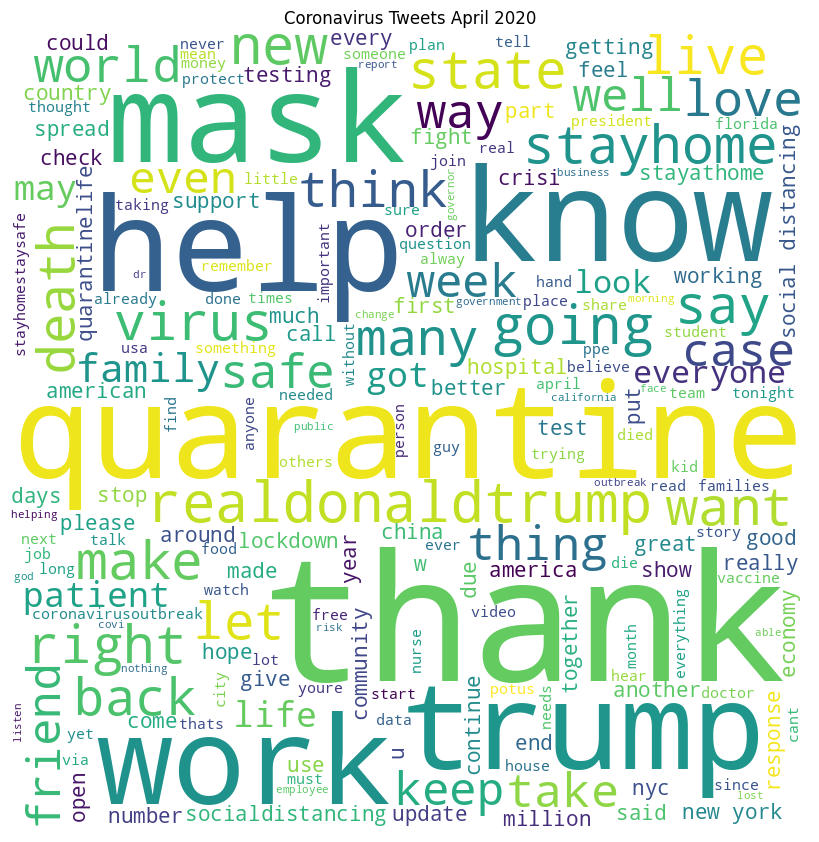

In [45]:
comment_words = ''
stopwords = set(stopwords)

# iterate through the csv file
for val in df.text:
    # typecaste each val to string
    val = str(val)
    # split the value
    tokens = val.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Coronavirus Tweets April 2020')
plt.savefig("coronavirus-tweets-word-cloud.jpeg");